In [313]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
import git
# find top-level of git repo and add it to the path
repo = git.Repo('.', search_parent_directories=True)

import sys
sys.path.insert(0, repo.working_tree_dir)

In [3]:
import utils.plotUtils as plu

In [4]:
def random_poisson(mu, sigma=None, size=1):
    if sigma is None:
        return np.random.poisson(mu, size)
    
    M = sigma **2 / mu
    K = (mu / sigma) ** 2
    return random_poisson(K, size=size) * M
    

In [5]:
def get_model(sig_x, bkg_x, data_x, bins=None, sig_w=None, bkg_w=None):
    h_sig, bins, _ = plt.hist(sig_x, bins=bins, weights=sig_w, histtype='step', linewidth=2)
    h_sig_err = np.sqrt(np.histogram(sig_x, bins=bins, weights=sig_w**2)[0])
    
    h_bkg, bins, _ = plt.hist(bkg_x, bins=bins, weights=bkg_w, alpha=0.5, label='bkg', color='blue')
    h_bkg_err = np.sqrt(np.histogram(bkg_x, bins=bins, weights=bkg_w**2)[0])

    plt.fill_between(
        bins, 
        np.append(h_bkg - h_bkg_err, 0), 
        np.append(h_bkg + h_bkg_err, 0), 
        step='post', 
        alpha=0.25, 
        color='grey', 
    )

    h_data = np.histogram(data_x, bins=bins)[0]
    h_data_err = np.sqrt(h_data)
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, h_data, yerr=np.sqrt(h_data), fmt='o', color='black', label='data')
    
    return (h_sig, h_sig_err), (h_bkg, h_bkg_err), (h_data, h_data_err)

In [6]:
def interp_at(value, x, y, npoints=3):
    nearest_points = np.sort(np.argsort(np.abs(x - value))[:npoints])
    return np.interp(value, x[nearest_points], y[nearest_points])
    
    

In [376]:
ms = np.arange(100, 150, 10)
R = np.random.uniform(0.8,1.2, size=1)
M = ms[np.random.randint(len(ms))]

In [377]:
gen_sig = lambda n, m=100 : np.random.normal(m, 0.05 * m, n)
gen_bkg = lambda n : np.random.lognormal( np.log(100),  0.5, n)

r_sig = 100
r_bkg = 5000

data_x = np.concatenate([gen_sig( int(R * r_sig), m=M ), gen_bkg( int(r_bkg) )])

In [378]:
from tqdm import tqdm

def minimize(L, atol=1e-6, rtol=1e-12, maxsteps=10000, verbose=False):
    nparams = len(list(L.parameters()))
    
    if verbose:
        print(f'Optimizing {nparams} parameters')
    
    if nparams == 0: return
    
    optimizer = torch.optim.Adam(L.parameters(), lr=0.01)
            
    loss = L()
    if loss.ndim == 1:
        loss = loss.mean()
        
    it = tqdm(range(maxsteps)) if verbose else range(maxsteps)
    for i in it:    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()       
        
        previous_loss = loss.item()
        
        loss = L()
        if loss.ndim == 1:
            loss = loss.mean()
            
        adiff = abs(previous_loss - loss.item())
        rdiff = abs(previous_loss - loss.item()) / abs(previous_loss)
            
        if (adiff and adiff < atol) or (rdiff and rdiff < rtol):
            break                

        if verbose and i % 10 == 0:
            it.set_description(f'loss={loss.item():.3f} absdiff={adiff:.3e} reldiff={rdiff:.3e}')
    
    if verbose:
        print(f'loss={loss.item():.3f} absdiff={adiff:.3e} reldiff={rdiff:.3e}')

In [432]:
mc_sig = 100
mc_bkg = 100
    
sig_x = np.stack([ gen_sig( int(r_sig * mc_sig), m=m ) for m in ms ], axis=1)
sig_w = np.ones_like(sig_x) / mc_sig

bkg_x = gen_bkg( int(r_bkg * mc_bkg) )
bkg_w = np.ones_like(bkg_x) / mc_bkg

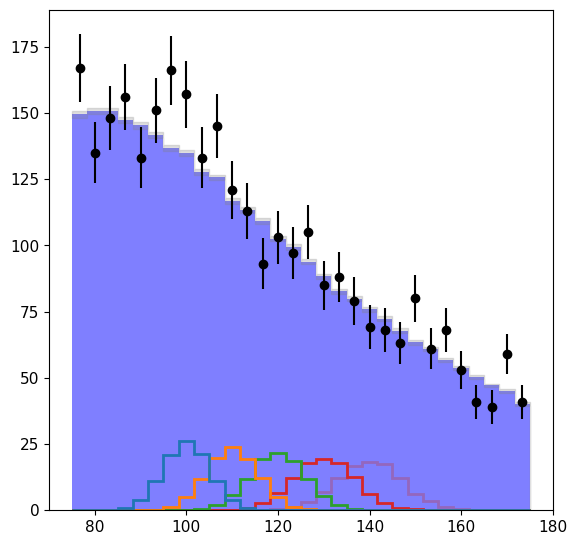

In [433]:
(s, serr), (b, berr), (d, derr) = get_model(sig_x, bkg_x, data_x, bins=np.linspace(75, 175, 31), sig_w=sig_w, bkg_w=bkg_w)
s, serr, b, berr, d, derr = [ torch.from_numpy(x) for x in [s, serr, b, berr, d, derr] ]

In [434]:

class Likelihood(torch.nn.Module):
    """
    P(nobs | nexp) = nexp^nobs / nobs! * exp(-nexp)

    log P(nobs | nexp) = nobs * log(nexp) - nexp - log(nobs!)
    """
    
    def __init__(self):
        super().__init__()
        
    def forward(self, nexp, nobs):
        log_nobs_factorial = torch.lgamma( nobs + 1 )
        log_poisson = nobs * torch.log(nexp) - nexp - log_nobs_factorial
        return - 2 * log_poisson

In [435]:


class BkgLikelihood(Likelihood):
    def __init__(self, k, b, m):
        super().__init__()
        self.k = k
        self.b = b
        self.m = m
        
    def forward(self):
        nexp = self.k * self.b
        obs = self.m
        return super().forward(nexp, obs)

In [436]:
class SignalBkgLikelihood(Likelihood):
    def __init__(self, r, s : torch.Tensor, b : torch.Tensor, d : torch.Tensor = None):
        super().__init__()
        self.r = r
        self.s = s
        self.b = b
        self.d = d if d is not None else b
        
    def forward(self):
        nexp = self.r * self.s + self.b
        return super().forward(nexp, self.d)

In [437]:
class NLL(torch.nn.Module):
    def __init__(self, *nlls):
        super().__init__()
        self.nlls = torch.nn.ModuleList(nlls)
        
    def forward(self):
        nll = sum( nll() for nll in self.nlls )
        return nll.sum(dim=-1)

In [438]:
class StatsHEP:
    
    def __init__(self, s, b, d, b_err, verbose=False):
        
        self.b_mc_k = b / b_err**2
        self.n_mc_b = self.b_mc_k * b
        
        self.r_mle = torch.nn.Parameter( torch.Tensor([1.0]), requires_grad=True )
        self.b_mle = torch.nn.Parameter( b, requires_grad=True )
        self.MLE = NLL(
            SignalBkgLikelihood(self.r_mle, s, self.b_mle, d),
            BkgLikelihood(self.b_mc_k, self.b_mle, self.n_mc_b),
        )
        
        minimize(self.MLE, verbose=verbose)
        
        self.r_scan = torch.linspace(0, 5, 101)
        self.b_scan = torch.nn.Parameter( self.b_mle.repeat(len(self.r_scan), 1), requires_grad=True )
        
        self.L = NLL(
            SignalBkgLikelihood(self.r_scan.unsqueeze(1), s, self.b_scan, d),
            BkgLikelihood(self.b_mc_k, self.b_scan, self.n_mc_b),
        )
        
        minimize(self.L, verbose=verbose)
        
    def __call__(self, r=None, b=None):
        if r is None:
            r = self.r_scan
            
        with torch.no_grad():
            nll = self.L() - self.MLE()
            
        return np.interp(r, self.r_scan.numpy(), nll.numpy())
    
    def tmu(self, r=None):
        if r is None: r = self.r_scan
        
        with torch.no_grad():
            nll = self.L() - self.MLE()
            
        return np.interp(r, self.r_scan.numpy(), nll.numpy())
    
    def tmu_pvalue(self, r=None):
        if r is None: r = self.r_scan
        tmu = self.tmu(r)
        return scipy.stats.chi2.sf(tmu, 1)
    
    def tilde_tmu(self, r=None):
        if r is None: r = self.r_scan
        
        with torch.no_grad():
            if self.r_mle.item() >= 0:
                nll = self.L() - self.MLE()
            else:
                nll = self.L()
                nll -= nll[0]
                
        return np.interp(r, self.r_scan.numpy(), nll.numpy())

    def q0(self):
        with torch.no_grad():
            if self.r_mle.item() >= 0:
                return (self.L() - self.MLE())[0]
            else:
                return 0
            
    def q0_pvalue(self):
        q0 = self.q0()
        return scipy.stats.norm.sf(np.sqrt(q0))
    
    def qmu(self, r=None):
        if r is None: r = self.r_scan
        
        tmu = self.tmu(r)            
        mask = self.r_mle.item() <= r
        return np.where(mask, tmu, 0)
        
    def qmu_pvalue(self, r=None):
        if r is None: r = self.r_scan
        
        qmu = self.qmu(r)
        return scipy.stats.norm.sf(np.sqrt(qmu))
    
    def upperlimit(self):
        r = np.linspace(0, 5, 1000)
        pvalue = self.qmu_pvalue(r)
        return interp_at(0.05, pvalue, r)
    
    def upperlimit_quantile(self, quantile=[0.025,0.16,0.5,0.84,0.975]):
        r_up = self.upperlimit()
        sigma = (r_up - self.r_mle.item()) / 1.64
        
        x = np.linspace(-4,4,1000)
        quantiles = np.vectorize(lambda q : interp_at(q, scipy.stats.norm.cdf(x), x))(quantile)
        
        return quantiles * sigma + r_up
        

In [439]:
class StatsCMS:
    def __init__(self, s, b, d, berr, verbose=False):
        self.obs = StatsHEP(s, b, d, berr, verbose=verbose)
        self.exp = StatsHEP(s, b, b, berr, verbose=verbose)

In [440]:
stats = [ StatsCMS(_s, b, d, berr) for _s in tqdm(s) ]

100%|██████████| 5/5 [00:01<00:00,  4.12it/s]


In [441]:
obs_lims = np.array([ s.obs.upperlimit() for s in stats ])
exp_lims = np.array([ s.exp.upperlimit_quantile() for s in stats ])

(<Figure size 650x650 with 1 Axes>, <Axes: >)

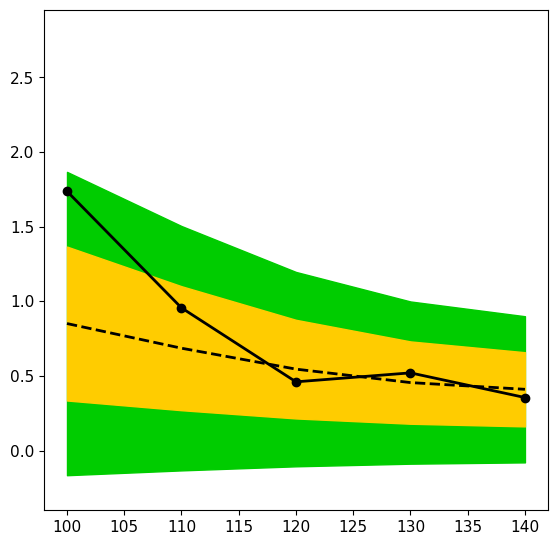

In [442]:
plu.graph_array(
    ms, obs_lims, g_color='black', g_label='Observed'
)

plu.graph_array(
    ms, exp_lims[:,2], g_color='black', g_linestyle='--', g_marker='none',
    g_label='Expected',
    figax='same'
)


plu.graph_array(
    ms, exp_lims[:,2], yerr=(exp_lims[:,4]-exp_lims[:,0])/2,
    fill_error=True, fill_alpha=1.0,
    g_color='#00cc00', g_marker=None, g_linewidth=0,
    figax='same'
)

plu.graph_array(
    ms, exp_lims[:,2], yerr=(exp_lims[:,1]-exp_lims[:,3])/2,
    fill_error=True, fill_alpha=1.0,
    g_color='#ffcc00', g_marker=None, g_linewidth=0,
    figax='same'
)